# trajectory buffers (25m)

this notebook created the buffers for all the trajectories and merge it with the big dataset following andres approach like this: df_foot = df[(df['Mode_id'] == 29) & (df['Deleted'] == False) & (df['Validated'] == True)

need to ask df_foot = df[(df['Mode_id'] == 29) & (df['Deleted'] == False) & (df['Validated'] == True) & (df['Interval Type_x'] == 'trip')] why its 0

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from functools import reduce

import geopandas as gpd
from shapely.geometry import LineString
from shapely.geometry import Polygon

import contextily as ctx

import osmnx as ox  

from pyproj import Transformer

In [2]:
data_path = '/home/s232713/data/'
trajectory_path = os.path.join(data_path, 'trajectories/')

In [3]:
gps_data_cleaned = pd.read_csv(data_path + "clean_points.csv", sep=';')
print(gps_data_cleaned.columns)

Index(['Interval ID', 'Latitude', 'Longitude'], dtype='object')


In [4]:
gdf = gpd.GeoDataFrame(
    gps_data_cleaned,
    geometry=gpd.points_from_xy(gps_data_cleaned["Longitude"], gps_data_cleaned["Latitude"]),
    crs="EPSG:4326"  # WGS84 latitude/longitude
)

lines = []

for interval_id, group in gdf.groupby("Interval ID"):
    # If you have "Sequence No." in the dataset, sort by it here:
    # group = group.sort_values("Sequence No.")
    
    coords = list(group.geometry)
    if len(coords) > 1:  # need at least 2 points to form a line
        line = LineString(coords)
        lines.append({"Interval ID": interval_id, "geometry": line})

lines_gdf = gpd.GeoDataFrame(lines, crs="EPSG:4326")

'''# save results
# As GeoJSON (good for quick plotting/sharing)
lines_gdf.to_file(trajectory_path + "trips_lines.geojson", driver="GeoJSON") # saved as EPSG:4326

# Or as Shapefile (classic GIS format)
lines_gdf.to_file(trajectory_path + "trips_lines.shp")'''

print(f"Created {len(lines_gdf)} trip lines")

Created 14560 trip lines


In [5]:
# Reproject to metric CRS if not is gonna be a mess with distances
lines_gdf = lines_gdf.to_crs(epsg=25833)

# Create 25m buffers
lines_gdf["buffer"] = lines_gdf.buffer(25)

In [6]:
lines_gdf.head()

,Interval ID,geometry,buffer
0,264953,"LINESTRING (344397.507 6184439.112, 344427.284...","POLYGON ((344434.821 6184452.975, 344463.381 6..."
1,264954,"LINESTRING (344484.718 6184402.569, 344712.348...","POLYGON ((344715.062 6184402.566, 344717.463 6..."
2,264966,"LINESTRING (344314.42 6184362.998, 344332.346 ...","POLYGON ((344310.265 6184402.131, 344311.916 6..."
3,264967,"LINESTRING (344512.754 6184431.643, 344479.781...","POLYGON ((344495.503 6184385.536, 344493.447 6..."
4,265108,"LINESTRING (343634.704 6195735.738, 343607.17 ...","POLYGON ((335778.533 6188627.918, 335756.406 6..."


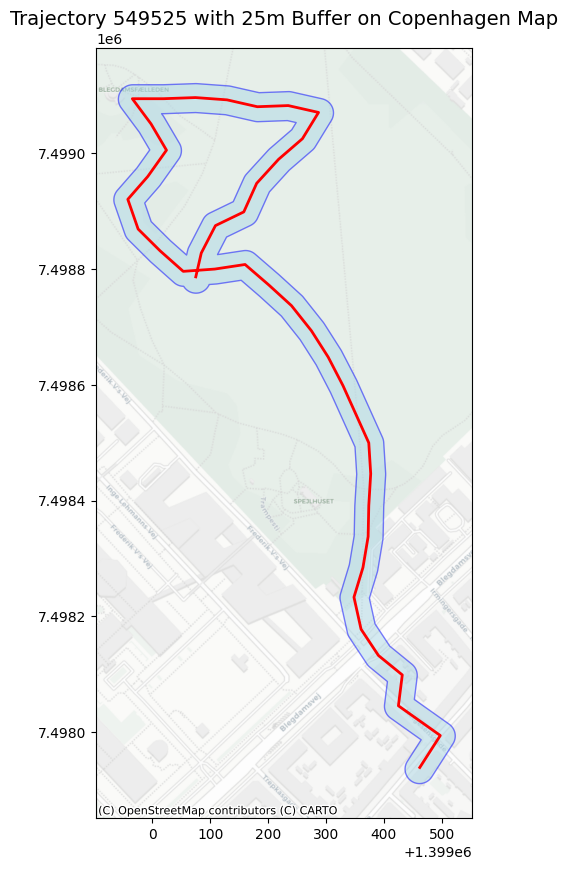

In [7]:
sample_id = 549525   # pick the first
line = lines_gdf.loc[lines_gdf["Interval ID"] == sample_id]

# Make sure geometries are projected in Web Mercator (for basemap)
line_web = line.to_crs(epsg=3857)
buffer_web = line_web.buffer(25)  # 25m buffer in projected CRS

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
buffer_web.plot(ax=ax, color="lightblue", alpha=0.5, edgecolor="blue")
line_web.plot(ax=ax, color="red", linewidth=2)

# basemap
ctx.add_basemap(ax, crs=line_web.crs, source=ctx.providers.CartoDB.Positron)

ax.set_title(f"Trajectory {sample_id} with 25m Buffer on Copenhagen Map", fontsize=14)
plt.show()

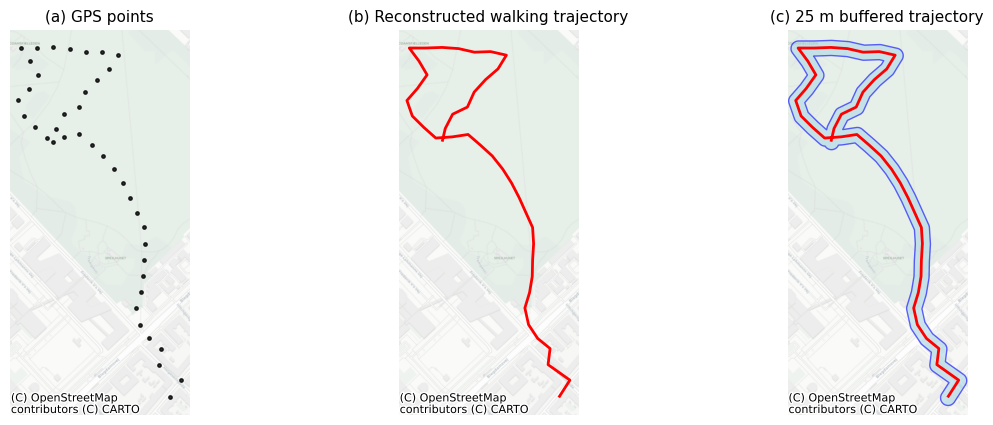

In [20]:
# =========================
# 3-PANEL FIGURE: GPS -> LINE -> BUFFER
# =========================

# Pick a representative trajectory
sample_id = 549525
points = gdf[gdf["Interval ID"] == sample_id].copy()
line = lines_gdf[lines_gdf["Interval ID"] == sample_id].copy()

# Reproject everything to Web Mercator for basemap
points_web = points.to_crs(epsg=3857)
line_web = line.to_crs(epsg=3857)
buffer_web = line_web.buffer(25)

# Create figure
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

# ---- Panel (a): Raw GPS points ----
points_web.plot(
    ax=axes[0],
    color="black",
    markersize=6,
    alpha=0.8
)
ctx.add_basemap(axes[0], crs=points_web.crs, source=ctx.providers.CartoDB.Positron)
axes[0].set_title("(a) GPS points", fontsize=11)
axes[0].axis("off")

# ---- Panel (b): LineString trajectory ----
line_web.plot(
    ax=axes[1],
    color="red",
    linewidth=2
)
ctx.add_basemap(axes[1], crs=line_web.crs, source=ctx.providers.CartoDB.Positron)
axes[1].set_title("(b) Reconstructed walking trajectory", fontsize=11)
axes[1].axis("off")

# ---- Panel (c): 25 m buffer ----
buffer_web.plot(
    ax=axes[2],
    color="lightblue",
    edgecolor="blue",
    alpha=0.6
)
line_web.plot(
    ax=axes[2],
    color="red",
    linewidth=2
)
ctx.add_basemap(axes[2], crs=line_web.crs, source=ctx.providers.CartoDB.Positron)
axes[2].set_title("(c) 25 m buffered trajectory", fontsize=11)
axes[2].axis("off")

#plt.tight_layout()
plt.subplots_adjust(wspace=0.01)

plt.show()

outpath = "/home/s232713/figures/gps_pipeline_example.pdf"
fig.canvas.draw()
fig.savefig(
    outpath,
    format="pdf",
    bbox_inches="tight"
)

plt.close(fig)


# merging the trajectories with the big dataset and then selecting foot activities

In [8]:
global_path = "/home/s232713/"
df = pd.read_pickle(os.path.join(global_path, "data/final_merged_data.pkl"))
# df.head()
df.columns.values

array(['Activity_concat', 'Mean_HR_cond', 'Mean_HR_cond_zscored',
       'RMSSD_activity_concat', 'RMSSD_50_points_timeframe',
       'pNN50_activity_concat', 'LF_activity_concat',
       'HF_activity_concat', 'LF_HF_ratio_activity_concat',
       'RMSSD_activity_concat_50_points',
       'pNN50_activity_concat_50_points', 'LF_activity_concat_50_points',
       'HF_activity_concat_50_points',
       'LF_HF_ratio_activity_concat_50_points', 'Valence', 'Arousal',
       'Stress', 'dist_stress', 'lat_x', 'lon_x', 'isDriver_x',
       'eda_MinTime', 'eda_MaxTime', 'eda_activity', 'eda_complexity',
       'eda_mobility', 'signal_rms', 'signal_acr_length',
       'signal_integral', 'signal_average_power', 'signal_mean',
       'signal_std', 'signal_max', 'signal_min', 'signal_range',
       'signal_kurtosis', 'signal_skew', 'signal_momentum',
       'mean_derivative', 'mean_derivative_negative', 'logsum_eda_signal',
       'auc_eda', 'eda_activity_NEW_EDA', 'eda_complexity_NEW_EDA',
       '

In [9]:
print(df['Activity_concat'].value_counts()) # put this one equal to 29=foot
print(df['Deleted'].value_counts()) # put this one false=not deleted by user during validation
print(df['Validated'].value_counts()) # put this one true=segment has been validated
print(df['Interval Type_x'].value_counts()) # put this one equal to trip=segment is trip 
print(df['Interval Type_y'].value_counts())

Activity_concat
Car/Truck                      2543
Foot                           2522
Change Travel Mode/Transfer    1460
Shopping                       1017
Bicycle                         982
Home                            886
Work                            771
Train                           459
Socialize                       457
Other                           317
Eat Out/Takeout                 315
Bus                             299
Metro                           272
Personal Errands/Tasks          271
Accompany/Dropoff/Pickup        261
Exercise/Play Sports            241
Entertainment                   215
Work Related                    137
Holiday                         135
Education                       129
Healthcare                       75
Community/Religious              51
Air                              12
Ferry/Boat                       10
Taxi                             10
Personal Mobility Device          1
Name: count, dtype: int64
Deleted
False    13842

In [10]:
print(len(df), len(lines_gdf))
print(df['Interval ID'].nunique(), lines_gdf['Interval ID'].nunique())

13848 14560
13848 14560


In [11]:
df_foot = df[(df['Mode_id'] == 29) & (df['Deleted'] == False) & (df['Validated'] == True) & (df['Interval Type_x'] == 'trip')]
print(len(df_foot), df_foot['Interval ID'].nunique()) # need to check this result with andre
df_foot = df[(df['Mode_id'] == 29) & (df['Deleted'] == False) & (df['Validated'] == True)]
print(len(df_foot), df_foot['Interval ID'].nunique())

0 0
2532 2532


In [12]:
print(len(lines_gdf), lines_gdf['Interval ID'].nunique())

14560 14560


In [13]:
df_foot_merged = pd.merge(df_foot, lines_gdf, on='Interval ID', how='inner')
print(len(df_foot_merged), df_foot_merged['Interval ID'].nunique())

2403 2403


In [14]:
df_foot_merged.head()

,Activity_concat,Mean_HR_cond,Mean_HR_cond_zscored,RMSSD_activity_concat,RMSSD_50_points_timeframe,pNN50_activity_concat,LF_activity_concat,HF_activity_concat,LF_HF_ratio_activity_concat,RMSSD_activity_concat_50_points,...,Motorcyclist_perc_Mapillary,Other Rider_perc_Mapillary,Car_perc_Mapillary,Truck_perc_Mapillary,Bus_perc_Mapillary,On Rails_perc_Mapillary,Motorcycle_perc_Mapillary,Bicycle_perc_Mapillary,geometry,buffer
0,Foot,118.310243,2.501799,30.165853,135.866640,0.090909,1.491876,15.911834,0.093759,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (335899.71 6188593.335, 335881.075 ...","POLYGON ((335872.971 6188539.416, 335876.117 6..."
1,Foot,61.236816,-0.694272,79.448426,63.831307,0.395833,977.797097,1072.080871,0.912055,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (335892.114 6188608.105, 335934.601...","POLYGON ((335878.035 6188579.886, 335866.803 6..."
2,Foot,72.921468,-0.039940,179.432564,151.101521,0.875000,315.163092,2397.064478,0.131479,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (343490.577 6195421.227, 343478.45 ...","POLYGON ((343455.472 6195439.666, 343454.605 6..."
3,Foot,103.608392,1.678506,NaN,27.387029,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (334375.122 6189113.655, 334343.433...","POLYGON ((334203.756 6189152.499, 334207.624 6..."
4,Foot,101.686300,1.570870,82.890378,62.220357,0.428571,173.886405,1093.223293,0.159058,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (334209.326 6188845.915, 334102.202...","POLYGON ((334105.126 6188808.472, 334102.796 6..."


In [15]:
df_foot_merged.to_pickle(os.path.join(data_path, "trajectories/foot_data_trajectory_buffer.pkl"))

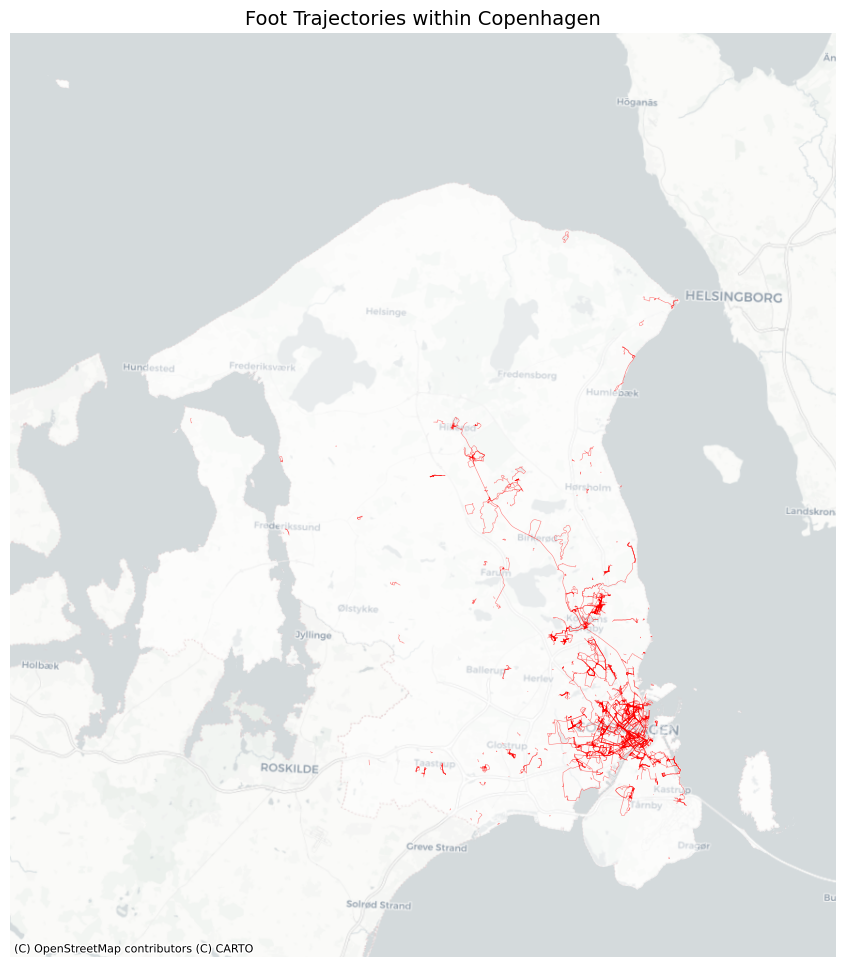

In [5]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx

boundary_path = "/home/s232713/data/grid_data/copenhagen_union_boundary.geojson"
traj_path = "/home/s232713/data/trajectories/FINAL_foot_data.pkl"

boundary_gdf = gpd.read_file(boundary_path)
df = pd.read_pickle(traj_path)

# Convert to GeoDataFrame using the 'geometry' column
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Clean + CRS setup
gdf = gdf[~gdf.geometry.is_empty & gdf.geometry.notna()]
gdf = gdf[gdf.is_valid]
gdf = gdf.set_crs("EPSG:25833", allow_override=True)
boundary_gdf = boundary_gdf.to_crs(gdf.crs)

# === PLOT ===
fig, ax = plt.subplots(figsize=(12, 12))
boundary_gdf.plot(ax=ax, color='white', edgecolor='none', linewidth=0.5, alpha=0.5)
gdf.plot(ax=ax, color='red', linewidth=0.3, alpha=0.5, aspect='auto')

ctx.add_basemap(ax, crs=gdf.crs, source=ctx.providers.CartoDB.Positron)

plt.title("Foot Trajectories within Copenhagen", fontsize=14)
plt.axis("off")
plt.show()

outpath = "/home/s232713/figures/map_foot_trajectories.pdf"
fig.savefig(
    outpath,
    format="pdf",
    bbox_inches="tight"
)

plt.close(fig)



In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

traj_path = "/home/s232713/data/trajectories/FINAL_foot_data.pkl"
df = pd.read_pickle(traj_path)
print(df['Interval ID'].nunique())


2018
(2018, 513)


In [2]:
# print(df[['Start Time_x', 'StartTime_day', 'starttime', 'Start Time_x', 'start_time']])
print(df['EndTime'])

0      2023-11-08 13:56:37
1      2023-11-09 11:37:05
2      2023-11-09 14:33:57
3      2023-11-09 18:12:10
4      2023-11-09 21:05:26
               ...        
2398   2024-07-12 19:59:20
2399   2024-07-14 17:09:44
2400   2024-07-14 17:36:17
2401   2024-07-18 23:10:07
2402   2024-07-19 01:06:21
Name: EndTime, Length: 2018, dtype: datetime64[ns]


In [4]:
import datetime

df['Start Time_x'] = pd.to_datetime(df['Start Time_x'])
df['EndTime'] = pd.to_datetime(df['EndTime'])

print('range: ', df['Start Time_x'].min(), ' to ', df['EndTime'].max())

range:  2023-11-08 13:53:57  to  2024-07-21 13:52:56


In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

traj_path = "/home/s232713/data/trajectories/FINAL_foot_data.pkl"
df_traj = pd.read_pickle(traj_path)

traj_final_path = "/home/s232713/data/trajectories/FINAL_foot_data.pkl"
df_traj_final = pd.read_pickle(traj_final_path)

In [2]:
df_traj.head()

,Activity_concat,Mean_HR_cond,Mean_HR_cond_zscored,RMSSD_activity_concat,RMSSD_50_points_timeframe,pNN50_activity_concat,LF_activity_concat,HF_activity_concat,LF_HF_ratio_activity_concat,RMSSD_activity_concat_50_points,...,Motorcyclist_perc_Mapillary,Other Rider_perc_Mapillary,Car_perc_Mapillary,Truck_perc_Mapillary,Bus_perc_Mapillary,On Rails_perc_Mapillary,Motorcycle_perc_Mapillary,Bicycle_perc_Mapillary,geometry,buffer
0,Foot,118.310243,2.501799,30.165853,135.866640,0.090909,1.491876,15.911834,0.093759,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((335872.971 6188539.416, 335876.117 6...","POLYGON ((335872.971 6188539.416, 335876.117 6..."
1,Foot,61.236816,-0.694272,79.448426,63.831307,0.395833,977.797097,1072.080871,0.912055,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((335878.035 6188579.886, 335866.803 6...","POLYGON ((335878.035 6188579.886, 335866.803 6..."
2,Foot,72.921468,-0.039940,179.432564,151.101521,0.875000,315.163092,2397.064478,0.131479,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((343455.472 6195439.666, 343454.605 6...","POLYGON ((343455.472 6195439.666, 343454.605 6..."
3,Foot,103.608392,1.678506,NaN,27.387029,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((334203.756 6189152.499, 334207.624 6...","POLYGON ((334203.756 6189152.499, 334207.624 6..."
4,Foot,101.686300,1.570870,82.890378,62.220357,0.428571,173.886405,1093.223293,0.159058,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((334105.126 6188808.472, 334102.796 6...","POLYGON ((334105.126 6188808.472, 334102.796 6..."


In [3]:
df_traj_final.head()

,Activity_concat,Mean_HR_cond,Mean_HR_cond_zscored,RMSSD_activity_concat,RMSSD_50_points_timeframe,pNN50_activity_concat,LF_activity_concat,HF_activity_concat,LF_HF_ratio_activity_concat,RMSSD_activity_concat_50_points,...,Motorcyclist_perc_Mapillary,Other Rider_perc_Mapillary,Car_perc_Mapillary,Truck_perc_Mapillary,Bus_perc_Mapillary,On Rails_perc_Mapillary,Motorcycle_perc_Mapillary,Bicycle_perc_Mapillary,geometry,buffer
0,Foot,118.310243,2.501799,30.165853,135.866640,0.090909,1.491876,15.911834,0.093759,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((335872.971 6188539.416, 335876.117 6...","POLYGON ((335872.971 6188539.416, 335876.117 6..."
1,Foot,61.236816,-0.694272,79.448426,63.831307,0.395833,977.797097,1072.080871,0.912055,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((335878.035 6188579.886, 335866.803 6...","POLYGON ((335878.035 6188579.886, 335866.803 6..."
2,Foot,72.921468,-0.039940,179.432564,151.101521,0.875000,315.163092,2397.064478,0.131479,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((343455.472 6195439.666, 343454.605 6...","POLYGON ((343455.472 6195439.666, 343454.605 6..."
3,Foot,103.608392,1.678506,NaN,27.387029,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((334203.756 6189152.499, 334207.624 6...","POLYGON ((334203.756 6189152.499, 334207.624 6..."
4,Foot,101.686300,1.570870,82.890378,62.220357,0.428571,173.886405,1093.223293,0.159058,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((334105.126 6188808.472, 334102.796 6...","POLYGON ((334105.126 6188808.472, 334102.796 6..."
